In [1]:
! rm -rf ConvNet_Viz/
! git clone https://github.com/eloiseberthier/ConvNet_Viz.git

Cloning into 'ConvNet_Viz'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 77 (delta 28), reused 59 (delta 16), pack-reused 0
Unpacking objects: 100% (77/77), done.


In [2]:
! ls

ConvNet_Viz  gdrive  sample_data


In [0]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('ConvNet_Viz')

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, Dense
from keras.layers import MaxPooling2D as KMaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.datasets import cifar10, mnist
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.models import load_model
 
from deconvnet.deconv2D import Deconv2D
from deconvnet.pool_unpool import MaxPooling2D, UndoMaxPooling2D
from deconvnet.forward_backward import truncated_model, backward_network

from hidden_patch import HiddenPatchAnalysis

Using TensorFlow backend.


In [0]:
(x_train, y_train0), (x_test, y_test0) = cifar10.load_data()
y_train = np_utils.to_categorical(y_train0)
y_test = np_utils.to_categorical(y_test0)

In [159]:
# For CIFAR-10 - simple model
"""
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=5, input_shape=(32, 32, 3), activation="relu"))
model.add(Conv2D(filters=16, kernel_size=5, input_shape=(32, 32, 3), activation="relu"))
model.add(KMaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(KMaxPooling2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(64, activation="tanh"))
model.add(Dense(10, activation="softmax"))

opt = SGD(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
"""

'\nmodel = Sequential()\nmodel.add(Conv2D(filters=16, kernel_size=5, input_shape=(32, 32, 3), activation="relu"))\nmodel.add(Conv2D(filters=16, kernel_size=5, input_shape=(32, 32, 3), activation="relu"))\nmodel.add(KMaxPooling2D(pool_size=2, strides=2))\nmodel.add(Conv2D(filters=64, kernel_size=3, activation="relu"))\nmodel.add(Conv2D(filters=64, kernel_size=3, activation="relu"))\nmodel.add(KMaxPooling2D(pool_size=2, strides=2))\nmodel.add(Flatten())\nmodel.add(Dense(64, activation="tanh"))\nmodel.add(Dense(10, activation="softmax"))\n\nopt = SGD(lr=0.001)\nmodel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])\n'

In [0]:
#model.summary()

In [0]:
# Best model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3), padding = "same")) # add padding
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(KMaxPooling2D(pool_size=2, strides=2))
model.add(BatchNormalization()) # add batchnorm
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu')) # 128
model.add(KMaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.25)) # added new dropout before last layer

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')) # 128
model.add(KMaxPooling2D(pool_size=2, strides=2)) # 
#model.add(BatchNormalization()) # removed second batchnorm 
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

opt = Adam(lr=0.0001, decay=1e-6) 
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 256)       147712    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 256)         0         
__________

In [45]:
model.fit(x_train, y_train, batch_size=64, epochs=20, validation_split=0.1)
# 40 epochs: 79.3%
# with batch norm: 30 epochs donne environ 80.6% + speed up at training time
# with padding: 40 ep -> 80.9% (idem)
# with one more droput : 40 ep 81.2 %
# changing the nber of deeper filters: 40ep 81.9%

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 23s 461us/step - loss: 0.6754 - acc: 0.7633 - val_loss: 0.6695 - val_acc: 0.7708
Epoch 2/20
50000/50000 [==============================] - 23s 457us/step - loss: 0.6582 - acc: 0.7682 - val_loss: 0.6367 - val_acc: 0.7845
Epoch 3/20
50000/50000 [==============================] - 23s 458us/step - loss: 0.6455 - acc: 0.7721 - val_loss: 0.6244 - val_acc: 0.7873
Epoch 4/20
50000/50000 [==============================] - 23s 455us/step - loss: 0.6282 - acc: 0.7789 - val_loss: 0.6197 - val_acc: 0.7879
Epoch 5/20
50000/50000 [==============================] - 23s 456us/step - loss: 0.6185 - acc: 0.7824 - val_loss: 0.6318 - val_acc: 0.7853
Epoch 6/20
50000/50000 [==============================] - 23s 455us/step - loss: 0.6067 - acc: 0.7869 - val_loss: 0.6235 - val_acc: 0.7872
Epoch 7/20
50000/50000 [==============================] - 23s 458us/step - loss: 0.5949 - acc: 0.7907 - val_loss: 0.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
#model.save('/content/gdrive/My Drive/final_filt_dpout_padded_batchnorm_deeper_model.h5')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [145]:
from google.colab import drive
drive.mount('/content/gdrive')
model = load_model('/content/gdrive/My Drive/padded_batchnorm_deeper_model.h5')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [54]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 256)       147712    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 256)         0         
__________

In [0]:
#model.evaluate(x_test, y_test)

# Visualization

In [0]:
def normalize(img):
    res = img.copy()
    M = img.max()
    m = -img.min()
    if m < M:
        idx = np.unravel_index(img.argmin(), img.shape)
        res[idx] = -img.max()
    else:
        idx = np.unravel_index(img.argmax(), img.shape)
        res[idx] = -img.min()
    return (255*(res-res.min())/(res.max()-res.min())).astype(np.uint8)

(-0.5, 31.5, 31.5, -0.5)

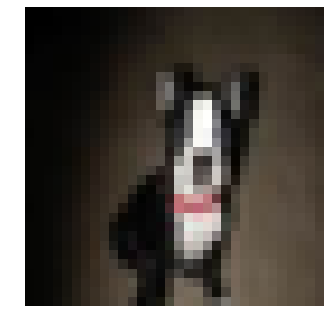

In [10]:
idx = 198# 198 chien bon # 551 cheval correct # 255 voiture -> assez parlante
plt.imshow(x_train[idx])
plt.axis("off")

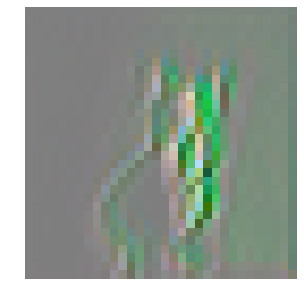

In [53]:
trunc_net = truncated_model(model, "conv2d_1")
backward_net = backward_network(trunc_net)

fwd_out = trunc_net.predict(x_train[[idx]])
_, _, filters = fwd_out[0].shape
f0 = fwd_out[0]
maxf = fwd_out[0][:,:,].max(axis=(0, 1)).argsort()[:-5:-1]
plt.figure(figsize=(5,5))

f = f0.copy()
fwd_out[0] = f
fwd_out[0][ :, :, np.arange(filters) != 31] = 0
backward_output = backward_net.predict(fwd_out)
img = normalize(backward_output[0])
plt.axis("off")
plt.imshow(img[:,:], cmap="gray")
plt.show()

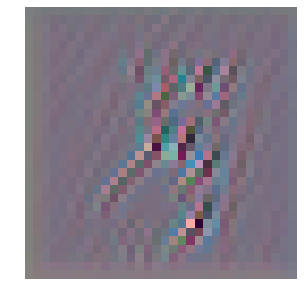

In [52]:
trunc_net = truncated_model(model, "conv2d_2")
backward_net = backward_network(trunc_net)

fwd_out = trunc_net.predict(x_train[[idx]])
_, _, filters = fwd_out[0].shape
f0 = fwd_out[0]
maxf = fwd_out[0][:,:,].max(axis=(0,1)).argsort()[:-5:-1]

plt.figure(figsize=(5,5))
f = f0.copy()
fwd_out[0] = f
fwd_out[0][ :, :, np.arange(filters) != 55] = 0
backward_output = backward_net.predict(fwd_out)
img = normalize(backward_output[0])
plt.axis("off")
plt.imshow(img[:,:], cmap="gray")
plt.show()

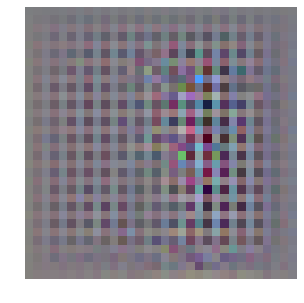

In [51]:
trunc_net = truncated_model(model, "conv2d_3") # very blue
backward_net = backward_network(trunc_net)

fwd_out = trunc_net.predict(x_train[[idx]])
_, _, _, filters = fwd_out[0].shape
f0 = fwd_out[0]
maxf = fwd_out[0][0,:,:,].max(axis=(0,1)).argsort()[:-5:-1]

plt.figure(figsize=(5,5))
f = f0.copy()
fwd_out[0] = f
fwd_out[0][:, :, :, np.arange(filters) != 227] = 0
backward_output = backward_net.predict(fwd_out)
img = normalize(backward_output[0])
plt.axis("off")
plt.imshow(img[:,:], cmap="gray")
plt.show()

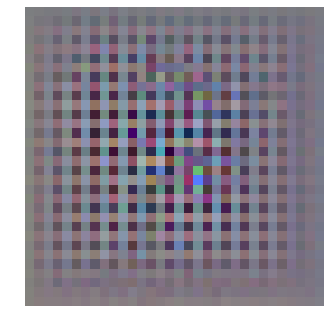

In [50]:
trunc_net = truncated_model(model, "conv2d_4")
backward_net = backward_network(trunc_net)

fwd_out = trunc_net.predict(x_train[[idx]])
_, _, _, filters = fwd_out[0].shape
f0 = fwd_out[0]
maxf = fwd_out[0][0,:,:,].max(axis=(0,1)).argsort()[:-5:-1]

f = f0.copy()
fwd_out[0] = f
fwd_out[0][:, :, :, np.arange(filters) != 54] = 0
backward_output = backward_net.predict(fwd_out)
img = img = normalize(backward_output[0])
plt.axis("off")
plt.imshow(img[:,:], cmap="gray")
plt.show()

# Hiding patches

In [0]:
Labels = {0 : 'airplane',
1 : 'automobile',
2 : 'bird',
3 : 'cat',
4 : 'deer',
5 : 'dog',
6 : 'frog',
7 : 'horse',
8 : 'ship',
9 : 'truck'}

In [0]:
res = model.predict(x_train[[idx]])
print(res)

[[1.96024666e-06 1.02888844e-04 1.37980783e-03 2.26293057e-02
  6.57921119e-05 9.72554147e-01 1.32422952e-04 2.79369392e-03
  2.16627086e-07 3.39831080e-04]]


In [0]:
def decode(res):
    #[(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tu
    l = []
    for i in range(len(res)):
        #ordr = np.argsort(-res[i]) # args
        #myres = -1.*np.sort(-res[i])
        loc = [(str(j), Labels[j], res[i][j]) for j in range(10)]
                
        l.append(sorted(loc, key=lambda x: x[2], reverse=True))
    return l

In [0]:
decode(res)

[[('5', 'dog', 0.97255415),
  ('3', 'cat', 0.022629306),
  ('7', 'horse', 0.002793694),
  ('2', 'bird', 0.0013798078),
  ('9', 'truck', 0.00033983108),
  ('6', 'frog', 0.00013242295),
  ('1', 'automobile', 0.000102888844),
  ('4', 'deer', 6.579211e-05),
  ('0', 'airplane', 1.9602467e-06),
  ('8', 'ship', 2.1662709e-07)]]

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from os import listdir
import keras
from keras.applications.vgg16 import VGG16, preprocess_input
import cv2
import tqdm
import time

class HiddenPatchAnalysis:
    
    def __init__(self, img_path, IMG_SIZE, STRIDE, PATCH_SIZE, model):
        self.IMG_SIZE = IMG_SIZE
        self.STRIDE = STRIDE
        self.PATCH_SIZE = PATCH_SIZE
        self.original = cv2.cvtColor(cv2.resize(cv2.imread(img_path), (self.IMG_SIZE, self.IMG_SIZE)),
                                     cv2.COLOR_RGB2BGR)
        self.model = model
        self.mask = None
        self.labels = None
        self.colors = None
        self.res_dict = None
        self.id = str(time.time())
        
    def hide_patch(self, patch_color = [150, 150, 150], patch_position = None):
        assert self.PATCH_SIZE%2==1, 'patch_size must be an odd number'
        hidden = self.original.copy()
        if patch_position is None:
            px = np.random.choice(self.IMG_SIZE)
            py = np.random.choice(self.IMG_SIZE)
        else:
            px = patch_position[0]
            py = patch_position[1]
        for i in range(px - self.PATCH_SIZE//2, px + self.PATCH_SIZE//2 + 1):
            for j in range(py - self.PATCH_SIZE//2, py + self.PATCH_SIZE//2 + 1):
                if i>=0 and i<self.IMG_SIZE and j>=0 and j<self.IMG_SIZE:
                    hidden[i, j] = patch_color
        return hidden, [px, py]

    def generate_hidden_images(self):
        hidden_images = {}
        for x in tqdm.tqdm(range(0, self.IMG_SIZE, self.STRIDE)):
            for y in range(0, self.IMG_SIZE, self.STRIDE):
                hidden, _ = self.hide_patch([150, 150, 150], patch_position = [x, y])
                hidden_images[(x, y)] = hidden
        return hidden_images
    
    def make_predictions(self, hidden_images):
        n = len(hidden_images)
        flatten = []
        for k in hidden_images.keys():
            flatten.append(hidden_images[k])
        flatten.append(self.original) # the last one is the original one
        flatten = np.array(flatten)
        to_recognize = tf.convert_to_tensor(flatten)
        res_hidden = self.model.predict(to_recognize, steps = n, verbose = 1)
        preds = decode(res_hidden)
        return preds
    
    def compute_plot_from_predictions(self):
        print('Generating hidden images')
        hidden_images = self.generate_hidden_images()
        print('Feeding the model')
        preds = self.make_predictions(hidden_images)
        print('Results collected')
        self.res_dict = {}
        k = 0
        for i in range(0, self.IMG_SIZE, self.STRIDE):
            for j in range(0, self.IMG_SIZE, self.STRIDE):
                self.res_dict[(i, j)] = preds[k]
                k+=1
        self.res_dict[(-1, -1)] = preds[-1]
        self.labels = []
        for i in self.res_dict.keys():
            if self.res_dict[i][0][1] not in self.labels:
                self.labels.append(self.res_dict[i][0][1])
        self.colors = 255 * np.random.rand(len(self.labels), 3)
        self.mask = self.original * 0
        for px in range(0, self.IMG_SIZE, self.STRIDE):
            for py in range(0, self.IMG_SIZE, self.STRIDE):
                c = self.colors[self.labels.index( self.res_dict[(px, py)][0][1],0)]
                for i in range(px - self.PATCH_SIZE//2, px + self.PATCH_SIZE//2 + 1):
                    for j in range(py - self.PATCH_SIZE//2, py + self.PATCH_SIZE//2 + 1):
                        if i>=0 and i<self.IMG_SIZE and j>=0 and j<self.IMG_SIZE:
                            self.mask[i, j] = c
                            
    def plot_mask(self, save = False):
        plt.figure(figsize = (15, 10), frameon=False)
        plt.subplot(221)
        plt.axis("off")
        plt.imshow(self.original)
        plt.subplot(222)
        plt.imshow(self.mask)
        plt.axis('off')
        plt.savefig(self.id+'_mask.png')
        
    def plot_class(self, some_class, save=False):
        hm = np.zeros((self.IMG_SIZE, self.IMG_SIZE))
        for px in range(0, self.IMG_SIZE, self.STRIDE):
            for py in range(0, self.IMG_SIZE, self.STRIDE):
                scores = self.res_dict[(px, py)]
                for k in range(len(scores)):
                    if scores[k][1] == some_class:
                        for i in range(px - self.PATCH_SIZE//2, px + self.PATCH_SIZE//2 + 1):
                            for j in range(py - self.PATCH_SIZE//2, py + self.PATCH_SIZE//2 + 1):
                                if i>=0 and i<self.IMG_SIZE and j>=0 and j<self.IMG_SIZE:
                                    hm[i, j] = scores[k][2]
        plt.figure(figsize = (15, 10), frameon=False)
        
        plt.subplot(221)
        plt.axis("off")
        plt.imshow(self.original)
        plt.subplot(222)
        h = plt.imshow(hm, cmap = plt.cm.YlOrRd_r)
        plt.colorbar(h)
        plt.axis('off')
        plt.savefig(self.id+'_class.png')
        
    def plot_legend(self):
        for i in range(len(self.labels)):
            plt.figure(figsize = (3, 3), frameon=False)
            plt.axis("off")
            blank_image = np.zeros((1, 2, 3), np.uint8)
            for x in range(1):
                for y in range(2):
                    blank_image[x, y, :] = self.colors[i]
            plt.imshow(blank_image)
            plt.title(self.labels[i], fontsize=20)

In [0]:
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False, 'axes.xtick': False})

In [0]:
idx = 380 # 55
cv2.imwrite('img.png', x_train[[idx]][0])

True

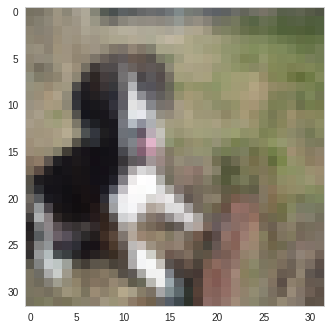

In [0]:
plt.imshow(x_train[[idx]][0])

In [0]:
HPA = HiddenPatchAnalysis('img.png', 32, 3, 7, model)

In [0]:
HPA.compute_plot_from_predictions()

100%|██████████| 11/11 [00:00<00:00, 714.84it/s]

Generating hidden images
Feeding the model


121/121 [==============================] - 6s 47ms/step
Results collected


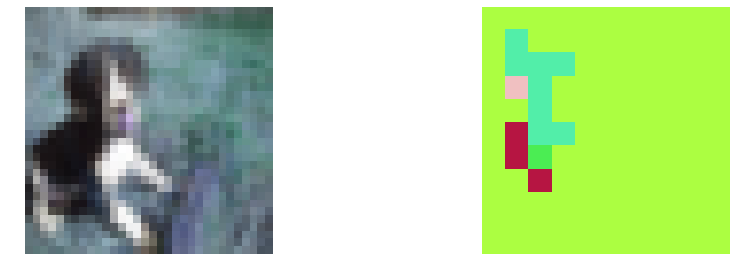

In [0]:
HPA.plot_mask()

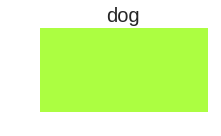

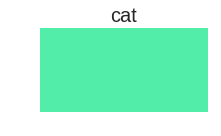

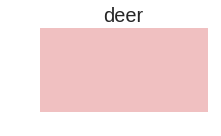

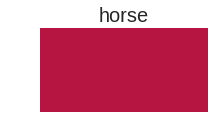

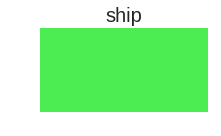

In [0]:
HPA.plot_legend()

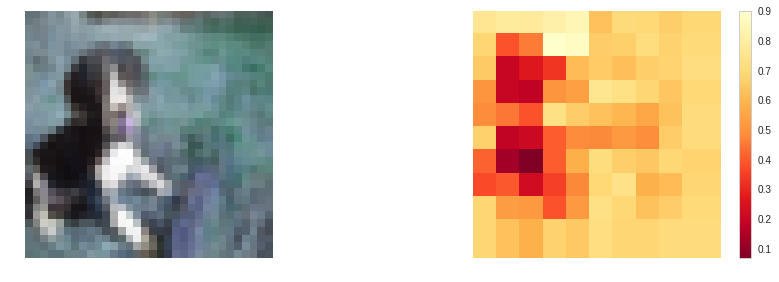

In [0]:
HPA.plot_class('dog')